# Assignment3

### Load data

In [2]:
# Adapted helper routine from Aurelien Geron: Hand-on Machine Learning with Scikit-learn & Tensorflow.

# Common imports
import numpy as np
import os
import skimage 

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
# PROJECT_ROOT_DIR = "/home/ao/workspace/cnn/assignment3/"
PROJECT_ROOT_DIR = "/home/ao/workspace/cnn/assignment3/"
NB_ID = "assignment3"

In [3]:
train_images = np.load(os.path.join(PROJECT_ROOT_DIR, NB_ID, 'rot_images_train.npy'))
train_flows = np.load(os.path.join(PROJECT_ROOT_DIR, NB_ID, 'rot_flows_train.npy'))
test_images = np.load(os.path.join(PROJECT_ROOT_DIR, NB_ID, 'rot_images_test.npy'))
test_flows = np.load(os.path.join(PROJECT_ROOT_DIR, NB_ID, 'rot_flows_test.npy'))

*make_RGB_combination* is a function to combine start images and goal images

In [4]:
def make_RGB_combination(img_arr):
    images = []
    for i in range(img_arr.shape[0]):
        seq_no = 0
        test1 = np.zeros(img_arr.shape[2:]+(3,))  
        test1[:,:,2] = img_arr[i,0+3*seq_no,:,:] 
        test1[:,:,1] = img_arr[i,1+3*seq_no,:,:] 
        test1[:,:,0] = img_arr[i,2+3*seq_no,:,:]
        
        seq_no = 1
        test2 = np.zeros(img_arr.shape[2:]+(3,))
        test2[:,:,2] = img_arr[i,0+3*seq_no,:,:] 
        test2[:,:,1] = img_arr[i,1+3*seq_no,:,:] 
        test2[:,:,0] = img_arr[i,2+3*seq_no,:,:]
        
        images.append(np.append(test1, test2, axis=0))
    return np.array(images)

def make_RGB(img_arr, img_no, seq_no ): 
    test = np.zeros(img_arr.shape[2:]+(3,))  
    test[:,:,2] = img_arr[img_no,0+3*seq_no,:,:] 
    test[:,:,1] = img_arr[img_no,1+3*seq_no,:,:] 
    test[:,:,0] = img_arr[img_no,2+3*seq_no,:,:]
    return test

def make_Greyscale(img_arr, img_no, seq_no ): 
    return img_arr[img_no,seq_no,:,:] 

In [5]:
# feature choosing and reshape ground truth
gt_train = train_flows[:,0:2,:,:].reshape((-1,2,64,64))
gt_train.shape

(1860, 2, 64, 64)

### Build model
I try 2 different ways of defining the size of training data set. The one size is 128\*64\*3 and another one is same as the initial shape which is 64\*64\*6. I use a same model structure defined by Keras to train the model with these 2 training data sets and find the data set whose size is **64\*64\*6** can result in a better results than the other one. 

I build a model with **6 convolutional layers with same kernel size(5\*5)**. In training process, I find there are 2 parameters have effect on the performance of model which are the number of filter and the size of  kernel. The more filters, the better performance. However, too many filters will increase time cost which means it is hard to trian high dimensions model. So, we should have a trade-off on time and performance. For me, 32 filters are enough to get a good model with relatively low time cost. For kernel size, 5\*5 is better than 4\*4 and 3\*3.

For **activation function**, I have tried *tanh, softmax* and *sigmoid* and so on. The combination of 5 *relu* for feature extraction and 1 *linear* for regression can get best performence in training and testing process. For **optimizer**, I choose *Adam* with 0.001 learning rate(LR) which is the best LR I have tried in training and *RMSprop* can also get a good performance on optimizition in training process. Learning rate plays a key role in backpropagation as even if very limited change in learning rate will result in huge difference in performance of models. For **loss function**, I use MSE. In my opinion, I think the difference of predicted flow and ground truth flow between each pixel can be used as the criterion. By comparing the images of perdicdtion and ground truth, we can see the prediction flow is good which proves the loss function is proper for this task.

The batch size has an effect on training and gradient descent. Usually, the larger of batch size, the faster to train the model. However, batch size depends on the RAM size. I modified the batch size to 30 with 15 epochs.

For **evaluating model**, I use Mean Squared Error(MSE) again to evaluate the performance of model. The one reason is that the mean difference of prediction and ground truth can directly reflect the performance of model which calculates the difference between every pixel and another reason is that I have tried Mean Absolute Error(MAE) and the model cannot perdict a good flow although the loss score is lower than 0.1. The images of prediction and ground truth prove that as well. In testing part, the MSE is about 0.103.

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model, Input
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import concatenate, Conv2D

In [79]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', data_format='channels_first',
                 input_shape=(6, 64, 64)))
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', data_format='channels_first'))
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', data_format='channels_first'))
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', data_format='channels_first'))
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', data_format='channels_first'))
model.add(Conv2D(2, kernel_size=(5, 5), activation='linear', padding='same', data_format='channels_first'))

adam = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=adam,
              metrics=['mae', 'mse'])
print(model.summary())

nEpochs = 15
# t1 = tf.transpose(train_images,[0,2,3,1])
history = model.fit(train_images, gt_train, batch_size=30, epochs=nEpochs, verbose=1,
                    validation_split=0.25)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 64, 64)        4832      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 64)        25632     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 64, 64)        25632     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 64, 64)        25632     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 64, 64)        25632     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 64, 64)         1602      
Total params: 108,962
Trainable params: 108,962
Non-trainable params: 0
__________________________________________________

In [92]:
gt_test = test_flows[:,0:2,:,:].reshape((-1,2,64,64))
test = model.predict(test_images)

In [96]:
mse = MeanSquaredError()
loss = mse(test, gt_test)
with tf.Session() as sess:
    print("Testing loss:{0}".format(sess.run(loss)))

Testing loss:0.10288388282060623


For test, Using 12th image to compare the prediction and ground truth.

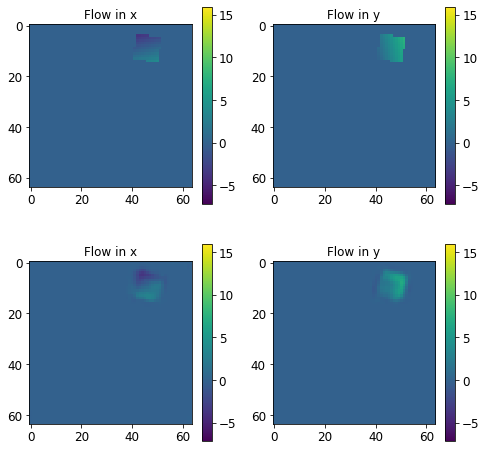

In [81]:
img_num = 12

fig, axes = plt.subplots(2, 2,figsize=(8,8))

# Find the min and max of the flow.
from matplotlib import colors
fl_min = np.min(test_flows[img_num,0:2,:,:])
fl_max = np.max(test_flows[img_num,0:2,:,:])
fl_min = np.min([fl_min,np.min(test[0,0:2,:,:])])
fl_max = np.max([fl_max,np.max(test[0,0:2,:,:])])
fl_norm = colors.Normalize(vmin=fl_min, vmax=fl_max)

# noise free flows
im = axes[0, 0].imshow(make_Greyscale(test_flows, img_num, 0 ))
im.set_norm(fl_norm)
axes[0, 0].set_title('Flow in x')
fig.colorbar(im,ax=axes[0, 0])

im = axes[0, 1].imshow(make_Greyscale(test_flows, img_num, 1 ))
im.set_norm(fl_norm)
axes[0, 1].set_title('Flow in y')
fig.colorbar(im,ax=axes[0, 1])

# noisy flows
im = axes[1, 0].imshow(make_Greyscale(test, img_num, 0 ))
im.set_norm(fl_norm)
axes[1, 0].set_title('Flow in x')
fig.colorbar(im,ax=axes[1, 0])

im = axes[1, 1].imshow(make_Greyscale(test, img_num, 1 ))
im.set_norm(fl_norm)
axes[1, 1].set_title('Flow in y')
fig.colorbar(im,ax=axes[1, 1])



### VGG16
In this part, I removed the last 2 blocks(8 layers) of VGG16 and added 3 deconvolutional layers. I used *Conv2DTranspose* to increase the size of feature map and the last deconvolutional layer is the **regression layer** which makes the shape of feature map to be the same as that of ground truth. I choosed *relu* and *linear* again and for optimizer I used **Adam** with **0.0005** learning rate. This is the best result I've got.

For the results in rotation data set, the performance of vgg16 model is not good on both 2 different data set from the training marks and the loss curve in training process. From the training marks, we can see there was a overfitting problem as the valdation loss increased although the training loss kept decreasing.

For this part, I've tried different optimizers ,activations and loss functions like mean_absolute_percentage_error and hinge and so on. Only the combination of **relu** and **linear** can get the best performance. For **loss function**, the model can converge if I use **MSE** and **only** using **MSE** the model can normal convert and learn although the performance is not good. The training loss will decrease from a big number and keep stable at **2.43** when I use mean_squared_logarithmic_error and the testing loss keep fluctuating. The predicted images reflect the bad performance of model as there isno flow in images.

In addition, I've tried to add batchnormalizion and dropout layer. The loss of MSE still decreased and the accuracy increased as well

In [84]:
def modelVGG16():
    model_vgg16 = VGG16(include_top=False, input_shape=(128, 64, 3))
    model_v2 = Model(model_vgg16.input, model_vgg16.layers[-9].output)

    x = model_v2.output

    x = Conv2DTranspose(256, kernel_size=(3, 3), activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(128, kernel_size=(3, 3), activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(1, kernel_size=(3, 3), activation='linear', strides=2, padding='same')(x)
    model1 = Model(inputs=model_vgg16.input, outputs=x)
    return model1


**For rotation data set**

In [32]:
model1 = modelVGG16()
print(model1.summary())
adam = tf.keras.optimizers.Adam(lr=0.0005)
model1.compile(optimizer=adam,
               loss=tf.keras.losses.MeanSquaredError(),
               metrics=['mae', 'mse'])

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 64, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 64, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 64, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 16, 128)       0   

In [69]:
train_images_combination = make_RGB_combination(train_images)
gt_train_new = train_flows[:,0:2,:,:].reshape((-1,128,64,1))

print("The new shape after combination in rotation data set:\n shape of training images:{0}".format(train_images_combination.shape))
print(" shape of ground truth:{0}".format(gt_train_new.shape))

The new shape after combination in rotation data set:
 shape of training images:(1860, 128, 64, 3)
 shape of ground truth:(1860, 128, 64, 1)


In [33]:
nEpochs = 15
# t1 = tf.transpose(train_images,[0,2,3,1])
history = model1.fit(train_images_combination, gt_train_new, batch_size=20, epochs=nEpochs, verbose=1,
                    validation_split=0.25)

Train on 1395 samples, validate on 465 samples
Epoch 1/15
1395/1395 [==============================] - 7s 5ms/sample - loss: 0.6660 - mean_absolute_error: 0.1289 - mean_squared_error: 0.6660 - val_loss: 0.5731 - val_mean_absolute_error: 0.1136 - val_mean_squared_error: 0.5731
Epoch 2/15
1395/1395 [==============================] - 6s 4ms/sample - loss: 0.6284 - mean_absolute_error: 0.1307 - mean_squared_error: 0.6284 - val_loss: 0.5673 - val_mean_absolute_error: 0.1232 - val_mean_squared_error: 0.5673
Epoch 3/15
1395/1395 [==============================] - 6s 4ms/sample - loss: 0.6190 - mean_absolute_error: 0.1365 - mean_squared_error: 0.6190 - val_loss: 0.5489 - val_mean_absolute_error: 0.1288 - val_mean_squared_error: 0.5489
Epoch 4/15
1395/1395 [==============================] - 6s 4ms/sample - loss: 0.5921 - mean_absolute_error: 0.1467 - mean_squared_error: 0.5921 - val_loss: 0.5279 - val_mean_absolute_error: 0.1577 - val_mean_squared_error: 0.5279
Epoch 5/15
1395/1395 [===========

In [85]:
# prediction
test_images_combination = make_RGB_combination(test_images)
test = model1.predict(test_images_combination)

# reshape prediction data from (*, 128, 64, 1)to (*, 2, 64, 64)
test = test.reshape(-1, 2, 64, 64)
print(test.shape)

(444, 2, 64, 64)


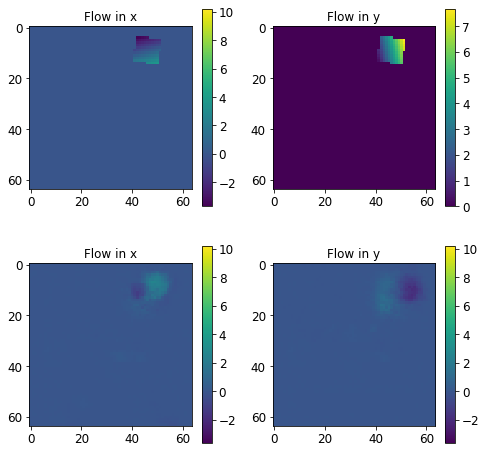

In [86]:
img_num = 12

fig, axes = plt.subplots(2, 2,figsize=(8,8))

# Find the min and max of the flow.
from matplotlib import colors
fl_min = np.min(test_flows[img_num,0:2,:,:])
fl_max = np.max(test_flows[img_num,0:2,:,:])
fl_min = np.min([fl_min,np.min(test[0,0:2,:,:])])
fl_max = np.max([fl_max,np.max(test[0,0:2,:,:])])
fl_norm = colors.Normalize(vmin=fl_min, vmax=fl_max)

# noise free flows
im = axes[0, 0].imshow(make_Greyscale(test_flows, img_num, 0 ))
im.set_norm(fl_norm)
axes[0, 0].set_title('Flow in x')
fig.colorbar(im,ax=axes[0, 0])

im = axes[0, 1].imshow(make_Greyscale(test_flows, img_num, 1 ))
axes[0, 1].set_title('Flow in y')
fig.colorbar(im,ax=axes[0, 1])

# noisy flows
im = axes[1, 0].imshow(make_Greyscale(test, img_num, 0 ))
im.set_norm(fl_norm)
axes[1, 0].set_title('Flow in x')
fig.colorbar(im,ax=axes[1, 0])

im = axes[1, 1].imshow(make_Greyscale(test, img_num, 1 ))
im.set_norm(fl_norm)
axes[1, 1].set_title('Flow in y')
fig.colorbar(im,ax=axes[1, 1])



**For mixed data set**

In [36]:
train_images_mix = np.load(os.path.join(PROJECT_ROOT_DIR, NB_ID, 'mix_images_train.npy'))
train_flows_mix = np.load(os.path.join(PROJECT_ROOT_DIR, NB_ID, 'mix_flows_train.npy'))
test_images_mix = np.load(os.path.join(PROJECT_ROOT_DIR, NB_ID, 'mix_images_test.npy'))
test_flows_mix = np.load(os.path.join(PROJECT_ROOT_DIR, NB_ID, 'mix_flows_test.npy'))

In [70]:
train_images_combination_mix = make_RGB_combination(train_images_mix)
gt_train_new_mix = train_flows_mix[:,0:2,:,:].reshape((-1,128,64,1))

print("The new shape after combination in mixed data set:\n shape of training images:{0}".format(train_images_combination.shape))
print(" shape of ground truth:{0}".format(gt_train_new.shape))

The new shape after combination in mixed data set:
 shape of training images:(1860, 128, 64, 3)
 shape of ground truth:(1860, 128, 64, 1)


In [57]:
model2 = modelVGG16()
# print(model2.summary())
adam = tf.keras.optimizers.Adam(lr=0.0005)
model2.compile(optimizer=adam,
               loss=tf.keras.losses.MeanSquaredError(),
               metrics=['mae', 'mse'])

In [58]:
nEpochs = 15
history2 = model2.fit(train_images_combination_mix, gt_train_new_mix, batch_size=20, epochs=nEpochs, verbose=1,
                    validation_split=0.25)

Train on 1395 samples, validate on 465 samples
Epoch 1/15
1395/1395 [==============================] - 6s 4ms/sample - loss: 0.6487 - mean_absolute_error: 0.1300 - mean_squared_error: 0.6487 - val_loss: 0.5403 - val_mean_absolute_error: 0.1161 - val_mean_squared_error: 0.5403
Epoch 2/15
1395/1395 [==============================] - 6s 4ms/sample - loss: 0.6173 - mean_absolute_error: 0.1296 - mean_squared_error: 0.6173 - val_loss: 0.5177 - val_mean_absolute_error: 0.1240 - val_mean_squared_error: 0.5177
Epoch 3/15
1395/1395 [==============================] - 6s 4ms/sample - loss: 0.5846 - mean_absolute_error: 0.1402 - mean_squared_error: 0.5846 - val_loss: 0.5015 - val_mean_absolute_error: 0.1419 - val_mean_squared_error: 0.5015
Epoch 4/15
1395/1395 [==============================] - 6s 4ms/sample - loss: 0.5481 - mean_absolute_error: 0.1408 - mean_squared_error: 0.5481 - val_loss: 0.4831 - val_mean_absolute_error: 0.1333 - val_mean_squared_error: 0.4831
Epoch 5/15
1395/1395 [===========

In [87]:
# prediction
test_images_combination_mix = make_RGB_combination(test_images_mix)
test2 = model2.predict(test_images_combination_mix)

# reshape testing data from (*, 128, 64, 1)to (*, 2, 64, 64)
test = test2.reshape(-1, 2, 64, 64)
print(test.shape)

(444, 2, 64, 64)


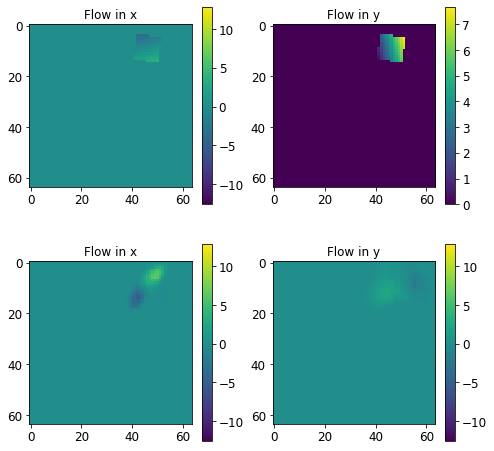

In [89]:
img_num = 12

fig, axes = plt.subplots(2, 2,figsize=(8,8))

# Find the min and max of the flow.
from matplotlib import colors
fl_min = np.min(test_flows_mix[img_num,0:2,:,:])
fl_max = np.max(test_flows_mix[img_num,0:2,:,:])
fl_min = np.min([fl_min,np.min(test[0,0:2,:,:])])
fl_max = np.max([fl_max,np.max(test[0,0:2,:,:])])
fl_norm = colors.Normalize(vmin=fl_min, vmax=fl_max)

# noise free flows
im = axes[0, 0].imshow(make_Greyscale(test_flows, img_num, 0 ))
im.set_norm(fl_norm)
axes[0, 0].set_title('Flow in x')
fig.colorbar(im,ax=axes[0, 0])

im = axes[0, 1].imshow(make_Greyscale(test_flows, img_num, 1 ))
axes[0, 1].set_title('Flow in y')
fig.colorbar(im,ax=axes[0, 1])

# noisy flows
im = axes[1, 0].imshow(make_Greyscale(test, img_num, 0 ))
im.set_norm(fl_norm)
axes[1, 0].set_title('Flow in x')
fig.colorbar(im,ax=axes[1, 0])

im = axes[1, 1].imshow(make_Greyscale(test, img_num, 1 ))
im.set_norm(fl_norm)
axes[1, 1].set_title('Flow in y')
fig.colorbar(im,ax=axes[1, 1])

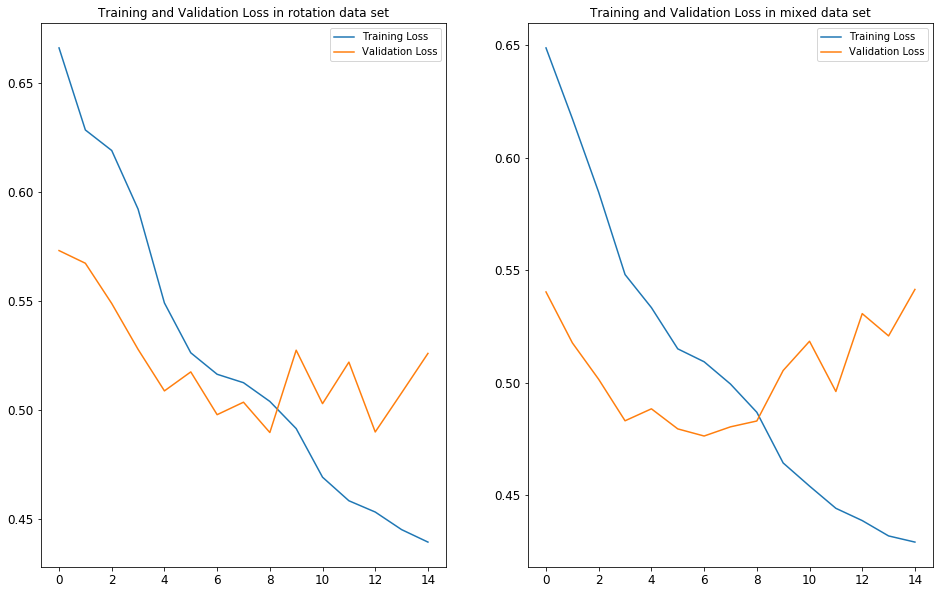

In [62]:
loss_rot = history.history['loss']
val_loss1_rot = history.history['val_loss']

loss_mix = history2.history['loss']
val_loss1_mix = history2.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss_rot, label='Training Loss')
plt.plot(epochs_range, val_loss1_rot, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss in rotation data set')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_mix, label='Training Loss')
plt.plot(epochs_range, val_loss1_mix, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss in mixed data set')
plt.show()

### Bonus
In this part, I defined a function to split start images and goal images named *get_RGB_images*. 

For new model, there are 5 convolutional layers and the last one is the regression layer. There is a layer implemented by *concatenate* function which is to combine the calculated features. The input data should be 2 groups which are start images and goal images respectively.

The performance of this model is worse than the original one. I tried different combination of learning rate, the number of layers and optimizers. The training and testing loss can be about **0.334** after 15 epochs. If keep training, the loss can be decreased. I also tried to change the shape from (\*, 2, 64, 64) to (\*, 1, 128, 64) while I got a worse result. 

In [1]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import concatenate, Conv2D, BatchNormalization, Dropout

def get_RGB_images(img_arr):
    images1 = []
    images2 = []
    for i in range(img_arr.shape[0]):
        seq_no0 = 0
        seq_no1 = 1
        test1 = np.zeros((3,) + img_arr.shape[2:])
        test1[2, :, :] = img_arr[i, 0 + 3 * seq_no0, :, :]
        test1[1, :, :] = img_arr[i, 1 + 3 * seq_no0, :, :]
        test1[0, :, :] = img_arr[i, 2 + 3 * seq_no0, :, :]
        test2 = np.zeros((3,) + img_arr.shape[2:])
        test2[2, :, :] = img_arr[i, 0 + 3 * seq_no1, :, :]
        test2[1, :, :] = img_arr[i, 1 + 3 * seq_no1, :, :]
        test2[0, :, :] = img_arr[i, 2 + 3 * seq_no1, :, :]
        images1.append(test1)
        images2.append(test2)
    return np.array(images1), np.array(images2)

gt_train = train_flows[:, 0:2, :, :].reshape((-1, 2, 64, 64))
start_train, target_train = get_RGB_images(train_images)
print(start_train.shape)

def creat_model_new(input_shape):
    input1 = Input(shape=input_shape)
    input2 = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', data_format='channels_first')(input1)
    x = Dropout(0.2)(x)
#     x = BatchNormalization()(x)
    x = Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', data_format='channels_first')(x)
    x = Dropout(0.3)(x)
#     x = BatchNormalization()(x)
    x = Model(inputs=input1, outputs=x)
    y = Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', data_format='channels_first')(input2)
    y = Dropout(0.5)(y)
#     y = BatchNormalization()(y)

    y = Conv2D(32, kernel_size=(5, 5), activation='linear', padding='same', data_format='channels_first')(y)
    y = Model(inputs=input2, outputs=y)
    input_com = concatenate([x.output, y.output], axis=1)
    reg = Conv2D(2, kernel_size=(5, 5), activation='relu', padding='same', data_format='channels_first')(input_com)
    return Model(inputs=[x.input, y.input], outputs=reg)

input_shape = (3, 64, 64)
# start = Input(shape=input_shape)
# target = Input(shape=input_shape)
# base_model = creat_model_new(input_shape)
# model = Model(inputs=[start, target], outputs=base_model.output)
model = creat_model_new(input_shape)

adam = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss=tf.keras.losses.mean_squared_logarithmic_error,
              optimizer=adam,
              metrics=['acc', 'mse'])
# model.compile(loss=tf.keras.losses.mean_squared_logarithmic_error,
#               optimizer=adam,
#               metrics=['mae', 'mse'])
print(model.summary())
batchSize = 30
nEpochs = 15
history3 = model.fit([start_train, target_train], gt_train, batch_size=batchSize, epochs=nEpochs, verbose=1,
                    validation_split=0.25)

NameError: name 'train_flows' is not defined

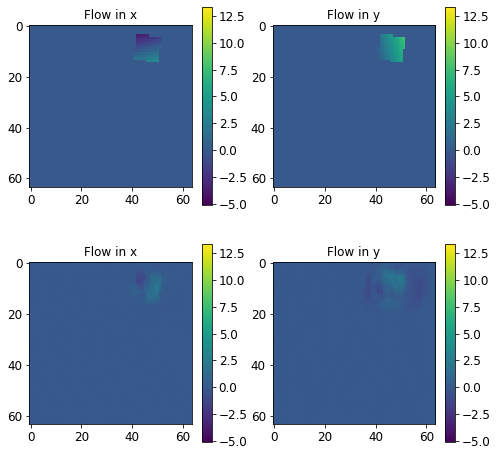

In [10]:
img_num = 12

fig, axes = plt.subplots(2, 2,figsize=(8,8))

# Find the min and max of the flow.
from matplotlib import colors
fl_min = np.min(test_flows[img_num,0:2,:,:])
fl_max = np.max(test_flows[img_num,0:2,:,:])
fl_min = np.min([fl_min,np.min(test[0,0:2,:,:])])
fl_max = np.max([fl_max,np.max(test[0,0:2,:,:])])
fl_norm = colors.Normalize(vmin=fl_min, vmax=fl_max)

# noise free flows
im = axes[0, 0].imshow(make_Greyscale(test_flows, img_num, 0 ))
im.set_norm(fl_norm)
axes[0, 0].set_title('Flow in x')
fig.colorbar(im,ax=axes[0, 0])

im = axes[0, 1].imshow(make_Greyscale(test_flows, img_num, 1 ))
im.set_norm(fl_norm)
axes[0, 1].set_title('Flow in y')
fig.colorbar(im,ax=axes[0, 1])

# noisy flows
im = axes[1, 0].imshow(make_Greyscale(test, img_num, 0 ))
im.set_norm(fl_norm)
axes[1, 0].set_title('Flow in x')
fig.colorbar(im,ax=axes[1, 0])

im = axes[1, 1].imshow(make_Greyscale(test, img_num, 1 ))
im.set_norm(fl_norm)
axes[1, 1].set_title('Flow in y')
fig.colorbar(im,ax=axes[1, 1])

Text(0.5, 1.0, 'Training and Validation Loss in rotation data set')

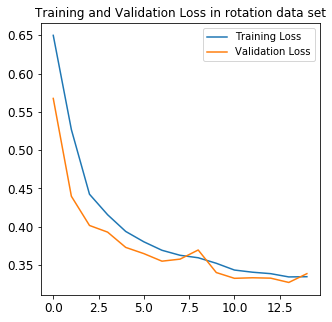

In [13]:
loss = history3.history['loss']
val = history3.history['val_loss']


epochs_range = range(15)

plt.figure(figsize=(5, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss in rotation data set')

In [ ]:
import tensorflow as tf
tf.__version__

In [16]:
gt_test = test_flows[:,0:2,:,:].reshape((-1,2,64,64))
test_start, test_goal = get_RGB_images(test_images)
test = model.predict([test_start, test_goal])
mse = MeanSquaredError()
loss = mse(test, gt_test)
with tf.compat.v1.Session() as sess:
    print("Testing loss:{0}".format(sess.run(loss)))

Testing loss:0.5336282849311829


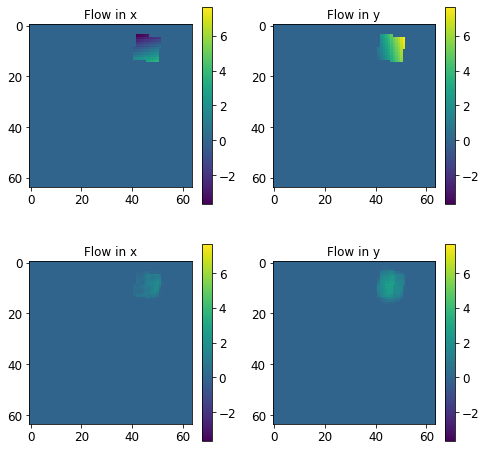

In [17]:
img_num = 12

fig, axes = plt.subplots(2, 2,figsize=(8,8))

# Find the min and max of the flow.
from matplotlib import colors
fl_min = np.min(test_flows[img_num,0:2,:,:])
fl_max = np.max(test_flows[img_num,0:2,:,:])
fl_min = np.min([fl_min,np.min(test[0,0:2,:,:])])
fl_max = np.max([fl_max,np.max(test[0,0:2,:,:])])
fl_norm = colors.Normalize(vmin=fl_min, vmax=fl_max)

# noise free flows
im = axes[0, 0].imshow(make_Greyscale(test_flows, img_num, 0 ))
im.set_norm(fl_norm)
axes[0, 0].set_title('Flow in x')
fig.colorbar(im,ax=axes[0, 0])

im = axes[0, 1].imshow(make_Greyscale(test_flows, img_num, 1 ))
im.set_norm(fl_norm)
axes[0, 1].set_title('Flow in y')
fig.colorbar(im,ax=axes[0, 1])

# noisy flows
im = axes[1, 0].imshow(make_Greyscale(test, img_num, 0 ))
im.set_norm(fl_norm)
axes[1, 0].set_title('Flow in x')
fig.colorbar(im,ax=axes[1, 0])

im = axes[1, 1].imshow(make_Greyscale(test, img_num, 1 ))
im.set_norm(fl_norm)
axes[1, 1].set_title('Flow in y')
fig.colorbar(im,ax=axes[1, 1])

In [9]:
gt_test = test_flows[:,0:2,:,:].reshape((-1,2,64,64))
test_start, test_goal = get_RGB_images(test_images)
test = model.predict([test_start, test_goal])
mse = MeanSquaredError()
loss = mse(test, gt_test)
with tf.Session() as sess:
    print("Testing loss:{0}".format(sess.run(loss)))

Testing loss:0.3373604714870453
